In [1]:
import numpy as np
import pandas as pd
#import uproot as ur

from keras.layers import Dense, Input
from keras.models import Model

import sys
sys.path.append("../src/")
import omnifold as of
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()

import uproot

/home/gmat/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-w1vnyomm because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def get_arrays(input_file, names):
    with uproot.open(input_file) as f:
        tree = f["dihadron_cuts"]
        arrays = []
        MCmatch_arr = tree["MCmatch"].array(library="np")
        rec_passDihadron_arr = tree["rec_passDihadron"].array(library="np")
        for name in names:
            
            reco_name = "rec_"+name
            true_name = "gen_"+name
            
            reco_arr = tree[reco_name].array(library="np")
            true_arr = tree[true_name].array(library="np")
            
            
            
            
            
            
            arr = tree[name].array(library="np")
            if name != "MCmatch":
                true_name = "true" + name
                true_arr = tree[true_name].array(library="np")
                mc_match = tree["MCmatch"].array(library="np")
                if("MC_" in input_file):
                    arr = arr[mc_match == 1]
                    true_arr = true_arr[mc_match == 1]
                arrays.append((arr, true_arr))
            else:
                arrays.append(arr)
    return arrays

def make_arrays_same_size(arr1, arr2, target_size):
    print(f"Monte Carlo size={len(arr1)}, Data size={target_size}")
    if len(arr1) < target_size:
        # If arr1 is smaller than target_size, duplicate random elements until it catches up
        inds_to_duplicate = np.random.choice(len(arr1), size=target_size-len(arr1))
        arr1 = np.concatenate((arr1, arr1[inds_to_duplicate]))
        arr2 = np.concatenate((arr2, arr2[inds_to_duplicate]))
        print(f"--> Duplicated {len(inds_to_duplicate)} elements to Monte Carlo")
    elif len(arr1) > target_size:
        # If arr1 is larger than target_size, cut out random elements
        inds_to_keep = np.random.choice(len(arr1), size=target_size, replace=False)
        print(f"--> Removed {len(arr1)-target_size} elements to Monte Carlo")
        arr1 = arr1[inds_to_keep]
        arr2 = arr2[inds_to_keep]
        
    else:
        print("Arrays are already the same size")
    return arr1, arr2

In [3]:
def load_data(file):
    arrays = get_arrays(file,feature_names)
    G = []
    S = []
    for i,arr in enumerate(arrays): 
        G.append(arr[0])
        S.append(arr[1])   
    return G,S

In [37]:
feature_names = ["x", "Q2", "z", "pTtot","Mh","phi_h"]
file0="../../projects/ana_v1/volatile/data/piplus_piminus/MC_RGA_3051_0.root"
#file1="../../projects/ana_v1/volatile/data/piplus_piminus/MC_RGA_3051_1.root"
file1="../../projects/ana_v1/volatile/data/piplus_piminus/nSidis_RGA_5036.root"
mc_reco, mc_true = load_data(file0)
data_reco, data_true = load_data(file1)

# Scale Monte Carlo to the same size as data
for i in range(len(mc_true)):
    target_size=len(data_reco[i])
    mc_true[i], mc_reco[i] = make_arrays_same_size(mc_true[i], mc_reco[i], target_size)

mc_reco = np.vstack(mc_reco).T
mc_true = np.vstack(mc_true).T
data_reco = np.vstack(data_reco).T
data_true = np.vstack(data_true).T

    
# theta0_G = np.vstack(theta0_G).T
# theta0_S = np.vstack(theta0_S).T
# theta1_G = np.vstack(theta1_G).T
# theta1_S = np.vstack(theta1_S).T

Monte Carlo size=19148, Data size=8283
--> Removed 10865 elements to Monte Carlo
Monte Carlo size=19148, Data size=8283
--> Removed 10865 elements to Monte Carlo
Monte Carlo size=19148, Data size=8283
--> Removed 10865 elements to Monte Carlo
Monte Carlo size=19148, Data size=8283
--> Removed 10865 elements to Monte Carlo
Monte Carlo size=19148, Data size=8283
--> Removed 10865 elements to Monte Carlo
Monte Carlo size=19148, Data size=8283
--> Removed 10865 elements to Monte Carlo


In [38]:
N = len(feature_names)

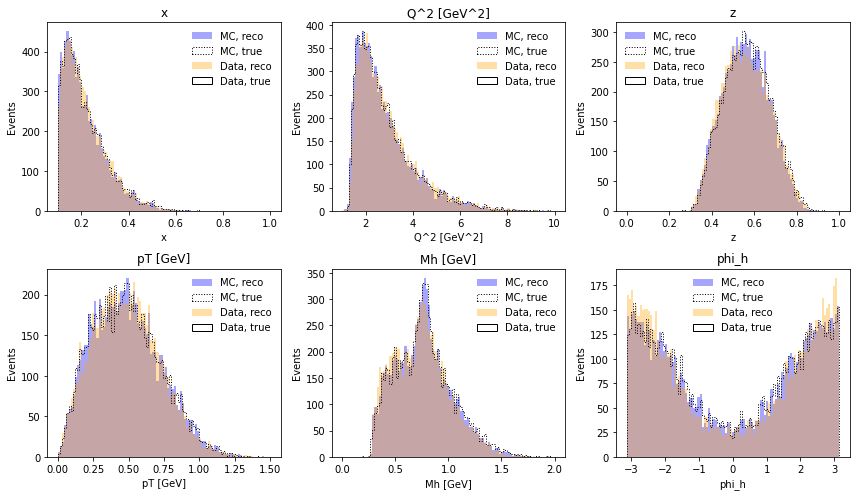

In [48]:

labels = ["x","Q^2 [GeV^2]","z","pT [GeV]","Mh [GeV]","phi_h"]
binning = [np.linspace(0.1,1,100),np.linspace(1,10,100),
           np.linspace(0,1,100),np.linspace(0,1.5,100),
           np.linspace(0,2,100),np.linspace(-3.1415,3.1415,100)]

ncols = int(np.ceil(len(binning)/2))
fig, axes = plt.subplots(2, ncols, figsize=(4*ncols,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(mc_reco[:,i],binning[i],color='blue',alpha=0.35,label="MC, reco")
    _,_,_=ax.hist(mc_true[:,i],binning[i],histtype="step",color='black',ls=':',linewidth=1,label="MC, true")
    _,_,_=ax.hist(data_reco[:,i],binning[i],color='orange',alpha=0.35,label="Data, reco")
    _,_,_=ax.hist(data_true[:,i],binning[i],histtype="step",color='black',label="Data, true")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

In [49]:
inputs = Input((len(feature_names), ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [50]:
N_Iterations = 2

mc = np.stack([mc_true, mc_reco], axis=1)

myweights = of.omnifold(mc,data_reco,N_Iterations,model_dis,verbose=1)


ITERATION: 1

STEP 1

Epoch 1/20
2/2 [==============================] - 0s 119ms/step - loss: 0.6998 - accuracy: 0.2580 - val_loss: 0.6919 - val_accuracy: 0.5337
Epoch 2/20
2/2 [==============================] - 0s 25ms/step - loss: 0.6936 - accuracy: 0.5618 - val_loss: 0.6931 - val_accuracy: 0.7213
Epoch 3/20
2/2 [==============================] - 0s 24ms/step - loss: 0.6939 - accuracy: 0.7223 - val_loss: 0.6925 - val_accuracy: 0.7061
Epoch 4/20
2/2 [==============================] - 0s 22ms/step - loss: 0.6927 - accuracy: 0.7038 - val_loss: 0.6912 - val_accuracy: 0.6290
Epoch 5/20
2/2 [==============================] - 0s 22ms/step - loss: 0.6913 - accuracy: 0.6213 - val_loss: 0.6908 - val_accuracy: 0.5168
Epoch 6/20
2/2 [==============================] - 0s 22ms/step - loss: 0.6908 - accuracy: 0.5072 - val_loss: 0.6908 - val_accuracy: 0.4627
Epoch 7/20
2/2 [==============================] - 0s 30ms/step - loss: 0.6904 - accuracy: 0.4648 - val_loss: 0.6906 - val_accuracy: 0.4757
Epo

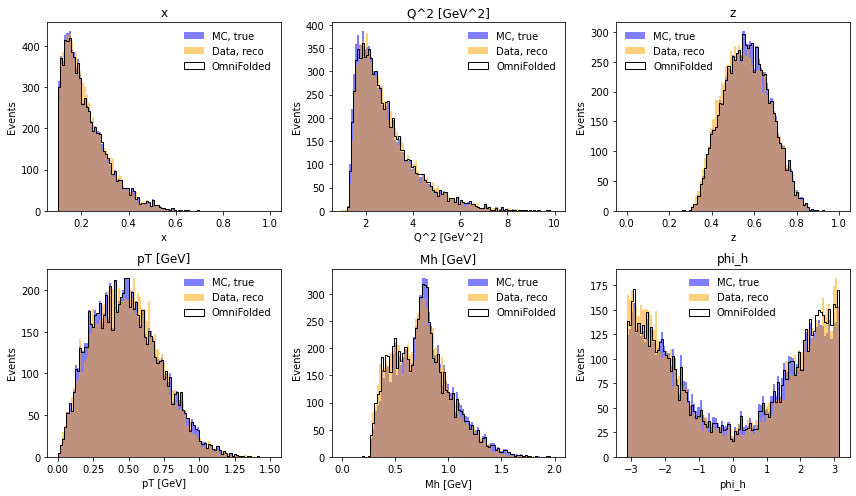

In [53]:
fig, axes = plt.subplots(2, ncols, figsize=(4*ncols,7))

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(mc_true[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(data_reco[:,i],binning[i],color='orange',alpha=0.5,label="Data, reco")
    _,_,_=ax.hist(mc_true[:,i],weights=myweights[-1, 0, :],bins=binning[i],color='black',histtype="step",label="OmniFolded")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
fig.tight_layout()

In [36]:
myweights[-1,0,:]

array([0.93347371, 1.03326476, 0.79783207, ..., 0.95064914, 0.92325366,
       0.90786999])